In [12]:
import numpy as np
from tqdm import tqdm
from PIL import Image

# RGB <-> YCbCr

In [2]:
YCC_vec = np.array([
    16,
    128,
    128
])
YCC_mat = np.array([
    [ .257,  .504,  .098],
    [-.148, -.291,  .439],
    [ .439, -.368, -.071]
])


def RGBtoYCC(pixel):
    return tuple(map(int, YCC_vec + np.matmul(YCC_mat, np.array(pixel))))

In [3]:
RGB_mat = np.array([
    [1.164,  .0  , 1.596],
    [1.164, -.392, -.813],
    [1.164, 2.017,  .0  ]
])


def YCCtoRGB(pixel):
    return tuple(map(int, np.matmul(RGB_mat, np.array(pixel) - YCC_vec)))

# CLAHE

In [33]:
def find_new_intensity(pixel_map, total_pixels, pbar):
    pixels_intensity = [0] * 256
    for x, row in enumerate(pixel_map):
        for y, el in enumerate(row):
            pixels_intensity[el[0]] = min(CONTRAST_LIMIT, pixels_intensity[el[0]] + 1)
            pbar.update()
    
    res = list(range(256))
    res[0] = pixels_intensity[0] * 255 / total_pixels
    for j in res[1:]:
        res[j] = res[j - 1] + pixels_intensity[j] * 255 / total_pixels

    return res

In [34]:
def elementary_CLAHE(img, pbar):
    h, w = img.size
    inp_pixel_map = img.load()
    new_pix_map = []
    for x in range(h):
        temp = []
        for y in range(w):
            temp += [RGBtoYCC(inp_pixel_map[x, y])]  # преобразование RGB в YCbCr
        new_pix_map += [temp]

    new_intensity = find_new_intensity(new_pix_map, w * h, pbar)

    change_intensity = lambda pixel: (new_intensity[pixel[0]], *pixel[1:])
    
    for x in range(h):
        for y in range(w):
            inp_pixel_map[x, y] = YCCtoRGB(change_intensity(new_pix_map[x][y]))

    return img

In [35]:
def CLAHE(img, pbar):
    global divg
    
    h, w = img.size

    for x in range(h // divg):
        for y in range(w // divg):
            area = (x * divg, y * divg, (x + 1) * divg, (y + 1) * divg)
            img.paste(elementary_CLAHE(img.crop(area), pbar), area)

    return img

In [8]:
def new_CLAHE(img):
    h, w = img.size
    inp_pixel_map = img.load()
    new_pix_map = []
    for x in range(h):
        temp = []
        for y in range(w):
            temp += [RGBtoYCC(inp_pixel_map[x, y])]
        new_pix_map += [temp]

    new_intensity = []
    with tqdm(total=h*w, leave=True) as pbar:
        for x in range(h):
            temp = []
            for y in range(w):
                targ_val = new_pix_map[x][y][0]
                x_range = max(0, x - divg), min(h, x + divg)
                y_range = max(0, y - divg), min(w, y + divg)
                total = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
                int_arr = [0] * 256
                for x1 in range(*x_range):
                    for y1 in range(*y_range):
                        int_arr[new_pix_map[x1][y1][0]] += 1
                temp += [sum(map(lambda x: min(CONTRAST_LIMIT, int_arr[x]), range(targ_val+1))) * 255 // total]
                pbar.update()
            new_intensity += [temp]

    for x in range(h):
        for y in range(w):
            inp_pixel_map[x, y] = YCCtoRGB((new_intensity[x][y], *new_pix_map[x][y][1:]))

    return img

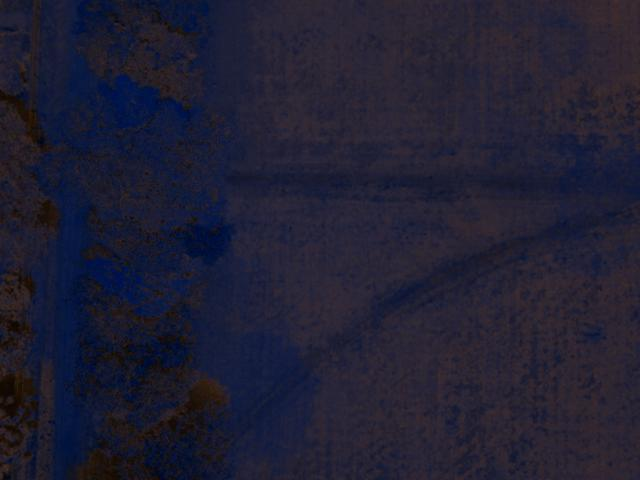

In [157]:
Image.open("C:\\Users\\809210\\Desktop\\l____l\\CITEC\\bad-conversed-images-3\\10180.jpg")

100%|███████████████████████████████████████████████████████████████████████| 307200/307200 [00:10<00:00, 28148.04it/s]


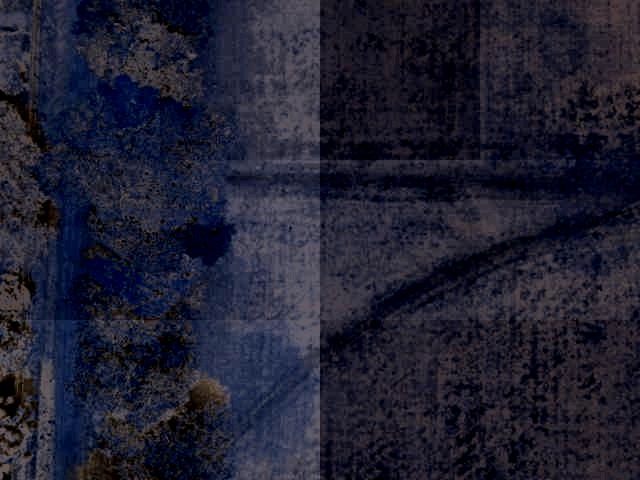

In [40]:
CONTRAST_LIMIT = 400
divg = 160
img = Image.open("C:\\Users\\809210\\Desktop\\l____l\\CITEC\\bad-conversed-images-3\\10180.jpg")
with tqdm(total = 640*480) as pbar:
    img = CLAHE(img, pbar)
img

100%|███████████████████████████████████████████████████████████████████████| 307200/307200 [00:10<00:00, 28888.78it/s]


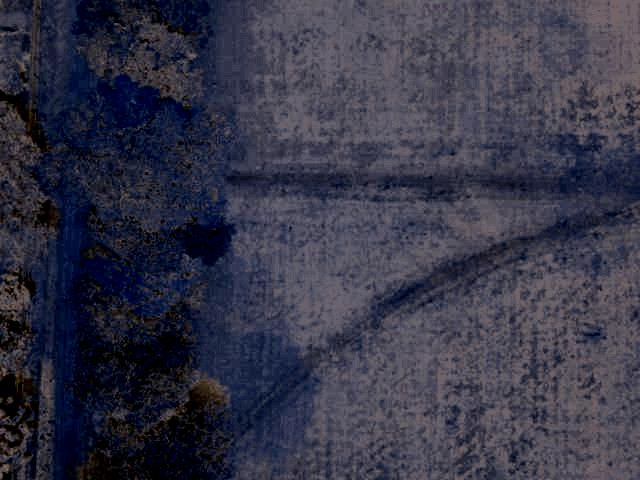

In [21]:
CONTRAST_LIMIT = 5000
img = Image.open("C:\\Users\\809210\\Desktop\\l____l\\CITEC\\bad-conversed-images-3\\10180.jpg")
with tqdm(total = 640*480) as pbar:
    img = elementary_CLAHE(img, pbar)
img

100%|████████████████████████████████████████████████████████████████████████| 307200/307200 [01:38<00:00, 3129.37it/s]


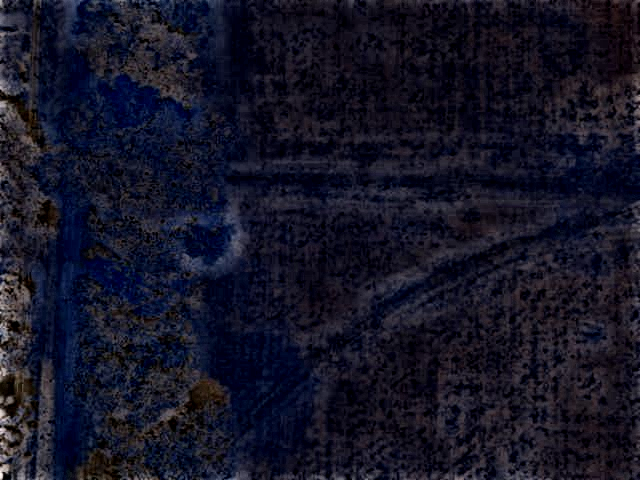

In [28]:
divg = 15
CONTRAST_LIMIT = 15
img = Image.open("C:\\Users\\809210\\Desktop\\l____l\\CITEC\\bad-conversed-images-3\\10180.jpg")
new_CLAHE(img)